# Figures for minEER publication 

## Datasets
### Longitudinal dataset
Located at: https://www.nature.com/articles/s41591-019-0559-3 BioProject PRJNA28331. See how mineer compares to other methods for host specificity.
###  Mock community pub
https://bmcmicrobiol.biomedcentral.com/articles/10.1186/s12866-016-0738-z. Perfomance on mock communities

In [1]:
# !pip install mineer

In [2]:
import mineer, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import seaborn as sns
from glob import glob

# Download data

In [27]:
"""Choose samples"""
df = pd.read_csv('data/SraRunTable.txt')
# Subset to amplicon
df = df[df['Assay Type'].eq('AMPLICON')]
# Order hosts by number of samples
host_order = df.groupby('host_subject_id').Run.nunique().sort_values(ascending=False).index
# Take first 4 samples from first 6 hosts
runs = df[df.host_subject_id.isin(host_order[:6])].sort_values(['host_subject_id', 'Collection_Date']).groupby('host_subject_id').Run.head(4).unique()
# Check the numbers
df[df.Run.isin(runs)].groupby('host_subject_id').Run.nunique()

host_subject_id
am    4
ba    4
bh    4
bj    4
cl    4
co    4
Name: Run, dtype: int64

In [30]:
"""Create command for download"""
cmd = f'fastq-dump {" ".join(runs)} --split-files -O data/fastqs'
print(cmd)

fastq-dump SRR9218919 SRR9218504 SRR9218917 SRR9218960 SRR9219118 SRR9219117 SRR9219251 SRR9219252 SRR9219081 SRR9219082 SRR9219040 SRR9219046 SRR9219064 SRR9218565 SRR9218508 SRR9218766 SRR9219212 SRR9218403 SRR9218404 SRR9218401 SRR9219669 SRR9219670 SRR9219663 SRR9219664 --split-files -O data/fastqs


# Algorithm explanation
1. Quality profile
2. EER space
3. After quality threshold applied and longest

In [265]:
"""Get test read with interesting profile"""
mal = 150
# Ingest file
file = mineer.utils.File('data/fastqs/SRR9660301_1.fastq', 'f', mal=mal)
# Get read that passes mineer
for r in file.reads:
    r.runMineer()
    if r.pass_qc_mineer:
        if r.trimpos_mineer[0] > 1:
            break
trimstart, trimend = r.trimpos_mineer

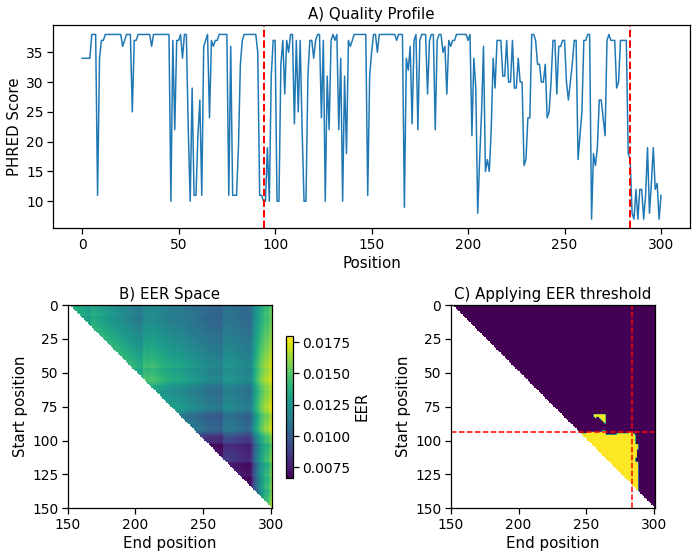

In [365]:
plt.figure(figsize=(10, 8))

"""Plot phred profile"""
ax1 = plt.subplot(2, 2, (1, 2))
# Plot profile
ax1.plot(r.untrimmed.phred)
# Plot truncation positoins
for pos in r.trimpos_mineer:
    ax1.axvline(pos, color='r', lw=2, ls='--')
ax1.set_xlabel('Position')
ax1.set_ylabel('PHRED Score')
ax1.set_title('A) Quality Profile')

"""Plot EER space"""
extent=[mal, r.untrimmed.length, file.mal, 0]

eerspace = mineer.mineer.eerspace(r.untrimmed.ee, file.mal)
eerspace_zoomed = eerspace[:file.mal, file.mal:]

ax2 = plt.subplot(223)
im = ax2.imshow(eerspace_zoomed, extent=extent)
ax2.set_ylabel('Start position')
ax2.set_xlabel('End position')
ax2.set_title('B) EER Space')
fig.colorbar(im, ax=ax2, label='EER', shrink=.7)



"""Plot masking with mae threshold"""
eerspace_masked = (eerspace_zoomed <= file.mae).astype(float)
nanx, nany = np.where(np.isnan(eerspace_zoomed))
eerspace_masked[nanx, nany] = np.nan

ax3 = plt.subplot(224)
ax3.imshow(eerspace_masked, extent=extent)
ax3.set_ylabel('Start position')
ax3.set_xlabel('End position')
ax3.axhline(trimstart, color='r', ls='--')
ax3.axvline(trimend, color='r', ls='--')
ax3.set_title('C) Applying EER threshold')

plt.tight_layout()
plt.show()

Applying the minEER algorithm. 

# Range of nreads

In [370]:
ns = [1000, 5000, 10000]

filepaths = glob('data/fastqs/*')

n = ns[0]
projectdir = f'data/results/n_{n}'
outdir = os.path.join(projectdir, 'truncated')
viz_outdir = os.path.join(projectdir, 'viz')
project = mineer.pipeline.truncPipeline(filepaths, '_1.fastq', '_2.fastq', nreads=n, outdir=outdir, viz_outdir=viz_outdir)

******** STARTING MINEER PIPELINE ********
		**** INPUTS ****
paired:                                        True
fwd_format:                                _1.fastq
rev_format:                                _2.fastq
nreads:                                        1000
mal:                                            100
mae:                                           0.01
aggmethod:                                   median
outdir:               data/results/n_1000\truncated
Files:                                           50
Samples:                                         25

SAMPLE-FILE PAIRS
                       Forward             Reverse
Sample                                            
SRR9660301  SRR9660301_1.fastq  SRR9660301_2.fastq
SRR9660304  SRR9660304_1.fastq  SRR9660304_2.fastq
SRR9660306  SRR9660306_1.fastq  SRR9660306_2.fastq
SRR9660307  SRR9660307_1.fastq  SRR9660307_2.fastq
SRR9660308  SRR9660308_1.fastq  SRR9660308_2.fastq
SRR9660309  SRR9660309_1.fastq  SRR9660309